In [6]:
import ee
import geemap
import pandas as pd
import dtale
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedKFold,train_test_split
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error,explained_variance_score,mean_absolute_percentage_error
import glob
import dask.dataframe as dd
from tpot import TPOTRegressor
import xarray as xr
from scipy import stats
from sklearn.svm import SVR
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import plot_partial_dependence
from warnings import filterwarnings
filterwarnings('ignore')
import plotly
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time
import plotly.express as px
import chart_studio.plotly as py
import folium
from folium.plugins import HeatMap
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
init_notebook_mode(connected = True)
from folium.plugins import FastMarkerCluster
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import os
from sklearn.inspection import permutation_importance

In [7]:
Map_S5P = geemap.Map()
Map_S5P

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [8]:
# Create a common region of interest (Texas)
roi = ee.Geometry.Polygon([[[-99.8142578125, 30.812343730092298],
          [-99.8142578125, 29.09908718595617],
          [-96.5623046875, 29.09908718595617],
          [-96.5623046875, 30.812343730092298]]])

In [9]:
# Data COllection for July
image_S5P = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P.addLayer(image_S5P, vis_params_S5P, "Sentinel-5P TROPOMI NO2")


image_LANDSAT8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('CLOUD_COVER') \
    .select('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol') \
    .median() \
    .clip(roi)

vis_params_L8 = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']
}


Map_S5P.addLayer(image_LANDSAT8, vis_params_L8, "Landsat-8")

image_S2_SR = ee.ImageCollection("COPERNICUS/S2") \
  .filterBounds(roi) \
  .filterDate('2018-07-01', '2018-07-31'); 

# This tells us what images are inside the collection
# These are the bands that we want to be displayed
S2_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A','B9', 'B11', 'B12']
bands=['B4', 'B3', 'B2']

# This turns the whole S2 collection into one image, finding the middle value for each pixel
image_S2_SR = image_S2_SR.median().select(S2_bands).clip(roi)

# This controls how we want the S2 image to be displayed
S2_display = {'bands': bands, 'min': 0, 'max': 0.3}

# This adds the S2_mosaic to the map, using the S2_display visual parameters, and giving it the name "S2_Image"
Map_S5P.addLayer(image_S2_SR, S2_display, 'Sentinel-S2_SR')

# This automatically pans the map to the middle of our area of interest
Map_S5P.centerObject(roi)

In [10]:
Map_S5P_sep = geemap.Map()
Map_S5P_sep

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [14]:
# Data COllection for September
image_S5P_sep = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-09-01', '2018-09-30') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P_sep = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P_sep.addLayer(image_S5P_sep, vis_params_S5P_sep, "Sentinel-5P TROPOMI NO2")


image_LANDSAT8_sep = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2018-09-01', '2018-09-30') \
    .sort('CLOUD_COVER') \
    .select('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol') \
    .median() \
    .clip(roi)

vis_params_L8_sep = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']
}


Map_S5P_sep.addLayer(image_LANDSAT8_sep, vis_params_L8_sep, "Landsat-8")

image_S2_SR_sep = ee.ImageCollection("COPERNICUS/S2") \
  .filterBounds(roi) \
  .filterDate('2018-09-01', '2018-09-30'); 

# This tells us what images are inside the collection
# These are the bands that we want to be displayed
S2_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A','B9', 'B11', 'B12']
bands=['B4', 'B3', 'B2']

# This turns the whole S2 collection into one image, finding the middle value for each pixel
image_S2_SR_sep = image_S2_SR_sep.median().select(S2_bands).clip(roi)

# This controls how we want the S2 image to be displayed
S2_display = {'bands': bands, 'min': 0, 'max': 3000}

# This adds the S2_mosaic to the map, using the S2_display visual parameters, and giving it the name "S2_Image"
Map_S5P.addLayer(image_S2_SR_sep, S2_display, 'Sentinel-S2_SR_sep')

# This automatically pans the map to the middle of our area of interest
Map_S5P.centerObject(roi)


In [15]:
#traing data for July
ground_truth= image_LANDSAT8.addBands(image_S5P).addBands(image_S2_SR)

work_dir = os.path.expanduser('/Users/mdnhuda/Desktop/PARC IEM Data/Correlation for Month with Scatter')
in_shp = os.path.join(work_dir, 'Texas_Shp.shp')

in_fc = geemap.shp_to_ee(in_shp)
Map_S5P.addLayer(in_fc, {}, 'Shape FIle Geometry')


proj = ee.Projection('EPSG:4326')
reproj_image = ground_truth.resample('bilinear').reproject(crs=proj, scale=30)


out_csv = os.path.join(work_dir, 'Combined_ESRI_S2_LandSat8_S5_Texas_TPOT July.csv')
geemap.extract_values_to_points(in_fc, reproj_image, out_csv)

df=pd.read_csv('Combined_ESRI_S2_LandSat8_S5_Texas_TPOT July.csv')

df=df.drop('system:index', axis=1)


Generating URL ...
Please wait ...
Data downloaded to /Users/mdnhuda/Desktop/PARC IEM Data/Correlation for Month with Scatter/Combined_ESRI_S2_LandSat8_S5_Texas_TPOT July.csv


In [16]:
dtale.show(df)

In [17]:
#traing data for September
ground_truth_sep= image_LANDSAT8_sep.addBands(image_S5P_sep).addBands(image_S2_SR_sep)

work_dir = os.path.expanduser('/Users/mdnhuda/Desktop/PARC IEM Data/Correlation for Month with Scatter')
in_shp = os.path.join(work_dir, 'Texas_Shp.shp')

in_fc = geemap.shp_to_ee(in_shp)
Map_S5P_sep.addLayer(in_fc, {}, 'Shape FIle Geometry')


proj = ee.Projection('EPSG:4326')
reproj_image_sep = ground_truth_sep.resample('bilinear').reproject(crs=proj, scale=30)


out_csv = os.path.join(work_dir, 'Combined_ESRI_S2_LandSat8_S5_Texas_TPOT Sep.csv')
geemap.extract_values_to_points(in_fc, reproj_image_sep, out_csv)

df_sep=pd.read_csv('Combined_ESRI_S2_LandSat8_S5_Texas_TPOT Sep.csv')
df_sep=df_sep.drop('system:index', axis=1)


2021-07-07 14:26:45,309 - ERROR    - PROJ: proj_identify: Cannot find proj.db
2021-07-07 14:26:45,312 - ERROR    - PROJ: proj_create_from_name: Cannot find proj.db


Generating URL ...
Please wait ...
Data downloaded to /Users/mdnhuda/Desktop/PARC IEM Data/Correlation for Month with Scatter/Combined_ESRI_S2_LandSat8_S5_Texas_TPOT Sep.csv


In [18]:
dtale.show(df_sep)

In [19]:
#df_sep.to_csv ('Combined_S2_LandSat8_S5_Los_Angeles_872_September.csv', index = False, header=True)

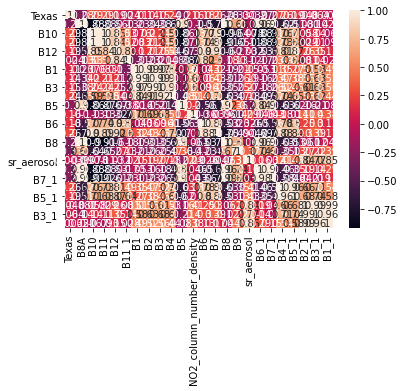

In [20]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

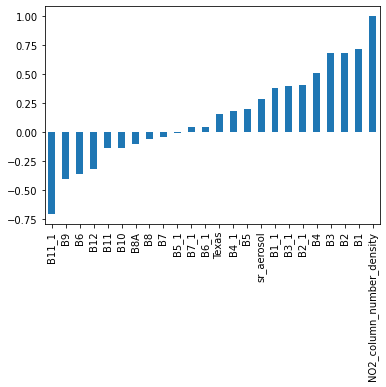

In [21]:
df.corr()['NO2_column_number_density'].sort_values().plot(kind='bar')

It looks like B1, B2, B3, B4, B10, B11, and sr-aerosol strongly correlate with the NO2 values. It will be good to see how do they perform in a fitted model.

In [22]:
dtale.show(df)

In [23]:
df.isnull().sum()

Texas                        0
B8A                          0
B10                          0
B11                          0
B12                          0
B11_1                        0
B1                           0
B2                           0
B3                           0
B4                           0
B5                           0
NO2_column_number_density    0
B6                           0
B7                           0
B8                           0
B9                           0
sr_aerosol                   0
B6_1                         0
B7_1                         0
B4_1                         0
B5_1                         0
B2_1                         0
B3_1                         0
B1_1                         0
dtype: int64

In [24]:
X=df.drop('NO2_column_number_density',axis=1).values
y=df['NO2_column_number_density'].values

scaler=MinMaxScaler()
X=scaler.fit_transform(X)
y=scaler.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [25]:
X_sep=df_sep.drop('NO2_column_number_density',axis=1).values
y_sep=df_sep['NO2_column_number_density'].values


scaler=MinMaxScaler()
X_sep=scaler.fit_transform(X_sep)
y_sep=scaler.fit_transform(y_sep.reshape(-1, 1))

X_train_sep, X_test_sep, y_train_sep, y_test_sep = train_test_split(X_sep, y_sep, test_size=0.30, random_state=42)


In [26]:
# cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
# model = TPOTRegressor(generations=4, population_size=50, scoring='neg_mean_absolute_error', cv=cv, verbosity=2, random_state=42, n_jobs=-1)
# model.fit(X_train, y_train)

# print('Training Accuracy : %.3f'% model.score(X_train,y_train))

# print('Test Accuracy : %.3f'%model.score(X_test,y_test))

In [27]:
#model.export('Combined_S2_LandSat8_S5_Los_Angeles_TPOT_tpot_best_model.py')

In [28]:
#from sklearn.ensemble import ExtraTreesRegressor
model = RandomForestRegressor(bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=7, min_samples_split=20, n_estimators=100)
model.fit(X_train, y_train)
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.999
Test Accuracy : 0.998


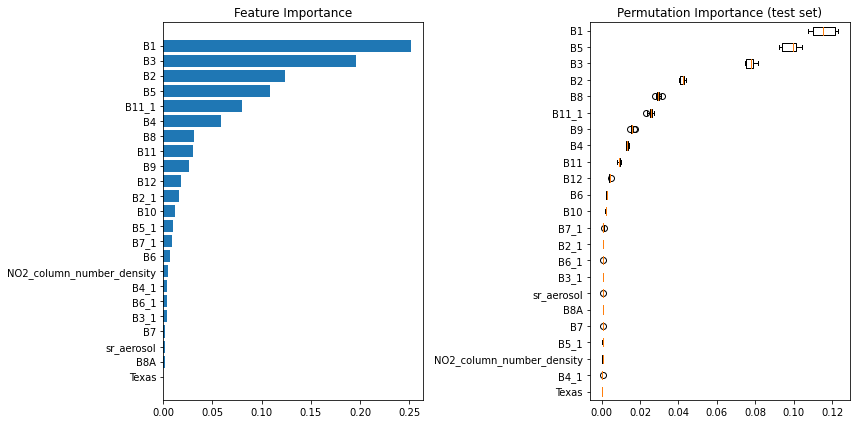

In [29]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.title('Feature Importance')
plt.yticks(pos, np.array(df.columns)[sorted_idx])
result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(df.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

Mean Squared Error = 0.14500839013717098
Mean absolute percentage error = 1971702030267.6733


Text(0, 0.5, 'NO2_column_number_density')

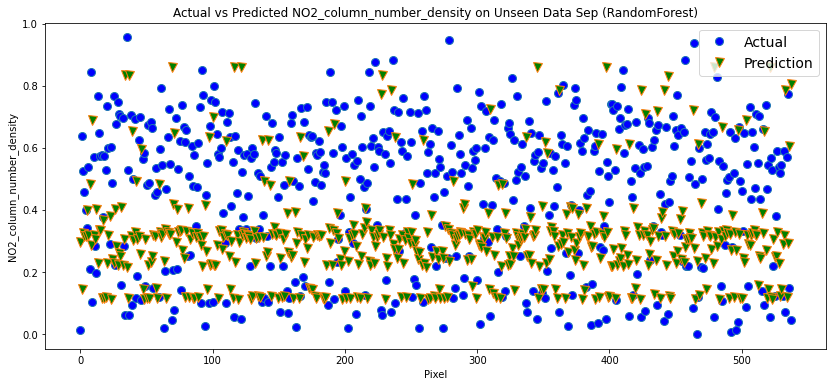

In [30]:
prediction_sep=model.predict(X_test_sep)
MSE=mean_squared_error(y_test_sep,prediction_sep)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test_sep,prediction_sep)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test_sep,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction_sep,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Unseen Data Sep (RandomForest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [31]:
#NO2_column_number_density=df['NO2_column_number_density']

In [32]:
#NO2_column_number_density

In [33]:
all_prediction=model.predict(X)

Text(0, 0.5, 'NO2_column_number_density')

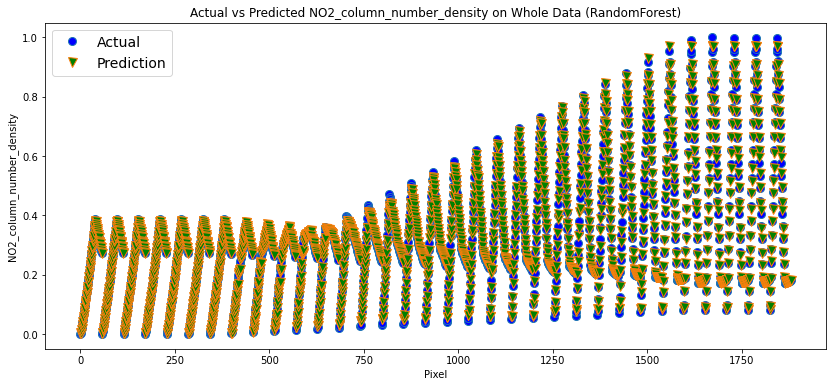

In [34]:
fig = plt.figure(figsize=(14,6))
plt.plot(y,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(all_prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Whole Data (RandomForest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

## Additional Methods follows below

In [35]:
model_params = {
    'svm': {
        'model': SVR(gamma='auto'),
        'params' : {
            'C': [10,20,50],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators': [5,10,15]
        }
    },
}

In [36]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_score

,model,best_score,best_params
0,svm,0.840166,"{'C': 10, 'kernel': 'linear'}"
1,random_forest,0.871823,{'n_estimators': 10}


In [37]:
#Rainforest Regression
model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=15)
model.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                  n_estimators=15)

In [38]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.980
Test Accuracy : 0.981


Mean Squared Error = 0.0007509413943552947
Mean absolute percentage error = 132785764950.49088


Text(0, 0.5, 'NO2_column_number_density')

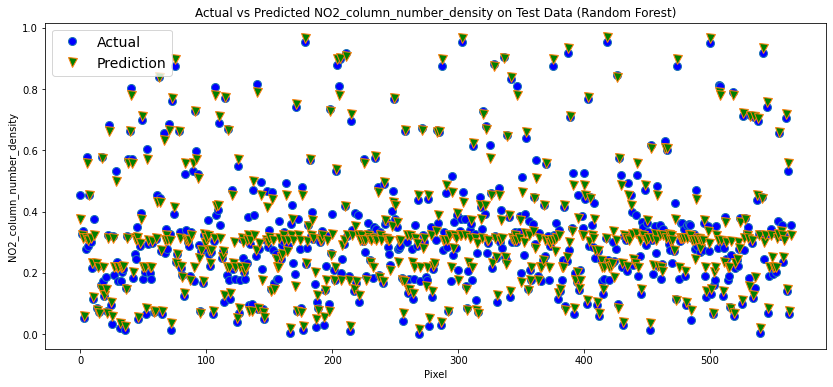

In [39]:
prediction=model.predict(X_test)
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

Mean Squared Error = 0.15205461130392428
Mean absolute percentage error = 2057217717627.9734


Text(0, 0.5, 'NO2_column_number_density')

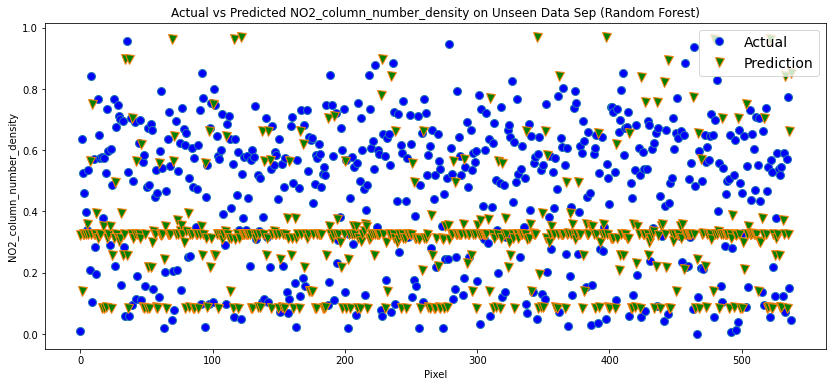

In [40]:
prediction_sep=model.predict(X_test_sep)
MSE=mean_squared_error(y_test_sep,prediction_sep)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test_sep,prediction_sep)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test_sep,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction_sep,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Unseen Data Sep (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [41]:
NO2_column_number_density=df['NO2_column_number_density']

In [42]:
X_all=X
all_prediction=model.predict(X_all)

Text(0, 0.5, 'NO2_column_number_density')

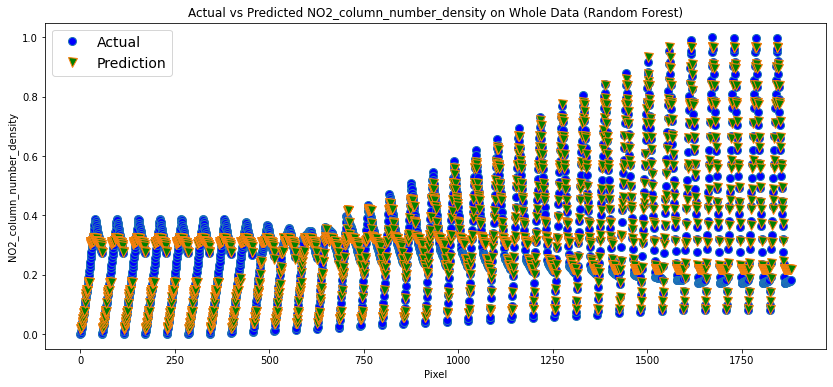

In [43]:
fig = plt.figure(figsize=(14,6))
plt.plot(y,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(all_prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Whole Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [44]:
#X.rename(index={0: "B1", 1: "B10", 2: "B11", 3: "B2",4: "B3", 5: "B4", 6: "B5", 7: "B6", 8: "B7"})

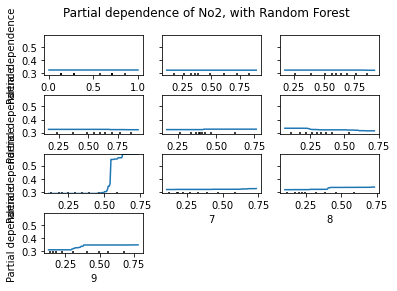

In [45]:
display = plot_partial_dependence(
       model, X, features=[0,1,2,3,4,5,6,7,8,9])

display.figure_.suptitle('Partial dependence of No2, with Random Forest')
display.figure_.subplots_adjust(hspace=0.5)

In [46]:
logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.790e+30
Date:                Wed, 07 Jul 2021   Prob (F-statistic):               0.00
Time:                        14:27:26   Log-Likelihood:                 43072.
No. Observations:                1316   AIC:                        -8.613e+04
Df Residuals:                    1307   BIC:                        -8.608e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -4.792e-15    1.6e-16    -30.019      0.0

# Linear Regression for Multioutput Regression

Mean Squared Error = 1.2799798584908876e-31
Mean absolute percentage error = 0.0011061946902672572
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.790e+30
Date:                Wed, 07 Jul 2021   Prob (F-statistic):               0.00
Time:                        14:27:26   Log-Likelihood:                 43072.
No. Observations:                1316   AIC:                        -8.613e+04
Df Residuals:                    1307   BIC:                        -8.608e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

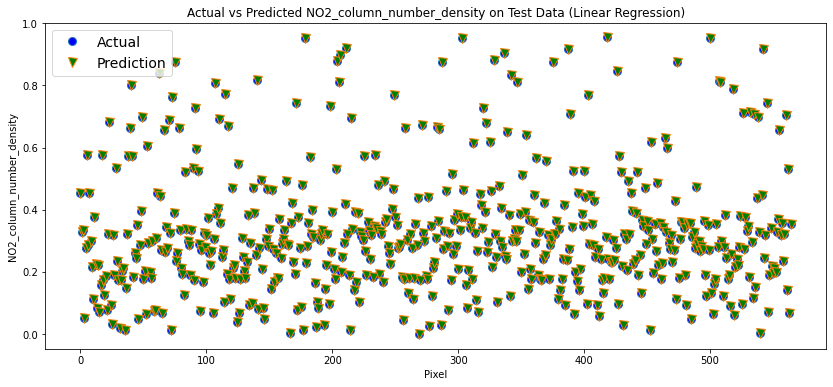

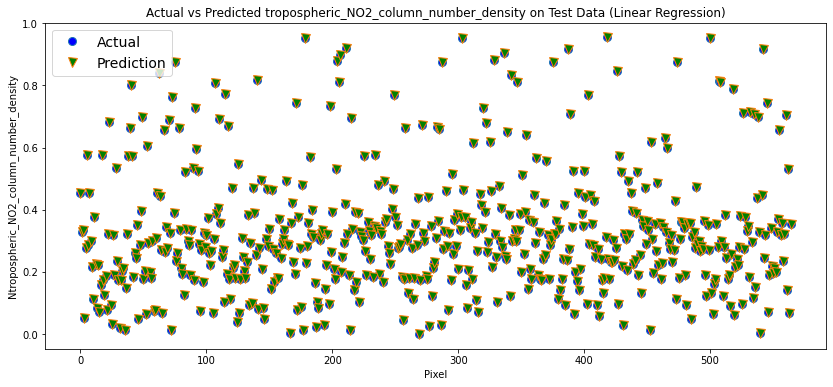

In [47]:
model = LinearRegression()
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
#print(prediction[0,0])

##
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Linear Regression)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted tropospheric_NO2_column_number_density on Test Data (Linear Regression)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('Ntropospheric_NO2_column_number_density')

logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

In [48]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 1.000
Test Accuracy : 1.000


# k-Nearest Neighbors for Multioutput Regression

Mean Squared Error = 0.0002490670749485422
Mean absolute percentage error = 52300765918.163216
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.790e+30
Date:                Wed, 07 Jul 2021   Prob (F-statistic):               0.00
Time:                        14:27:27   Log-Likelihood:                 43072.
No. Observations:                1316   AIC:                        -8.613e+04
Df Residuals:                    1307   BIC:                        -8.608e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

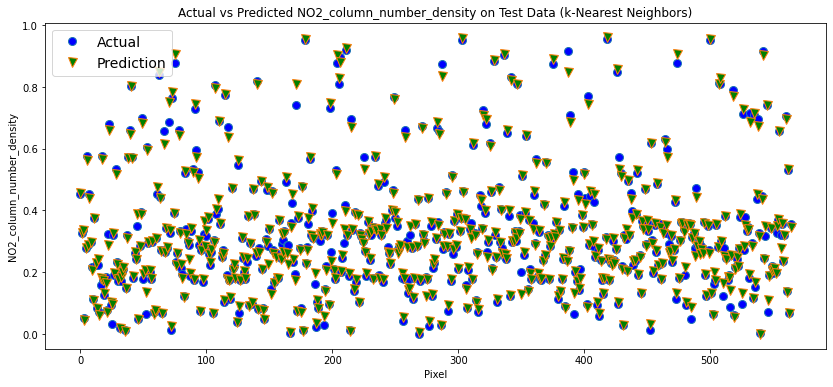

In [49]:
# define model
model = KNeighborsRegressor()
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
#print(prediction[0,0])

MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (k-Nearest Neighbors)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train ,X_train)
result=logit_model.fit()
print(result.summary())

In [50]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.996
Test Accuracy : 0.994


# Decision Tree for Multioutput Regression

Mean Squared Error = 0.0011341585576331028
Mean absolute percentage error = 357533670435.56586
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.790e+30
Date:                Wed, 07 Jul 2021   Prob (F-statistic):               0.00
Time:                        14:27:27   Log-Likelihood:                 43072.
No. Observations:                1316   AIC:                        -8.613e+04
Df Residuals:                    1307   BIC:                        -8.608e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

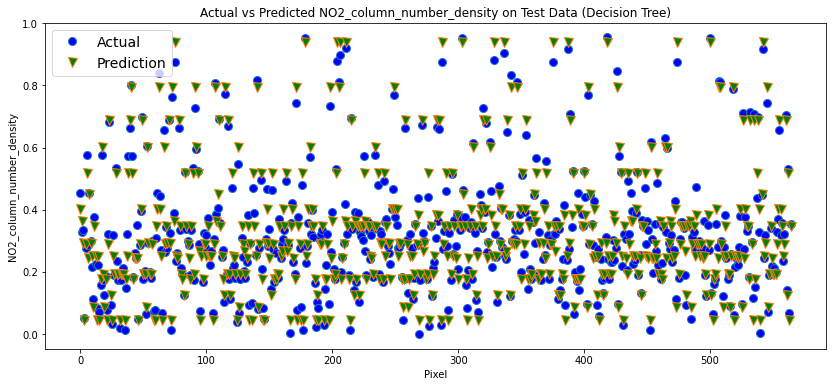

In [51]:
# define model
model = DecisionTreeRegressor(max_depth=8,
                           min_samples_split=5,
                           max_leaf_nodes=20)
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
#print(prediction)

MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Decision Tree)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train ,X_train)
result=logit_model.fit()
print(result.summary())

In [52]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.979
Test Accuracy : 0.971


In [53]:
X=df.drop('NO2_column_number_density',axis=1).values
y=df['NO2_column_number_density'].values

scaler=MinMaxScaler()
X=scaler.fit_transform(X)
y=scaler.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Mean Squared Error = 0.0003503989222455254
Mean absolute percentage error = 1242710874.3685613
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.790e+30
Date:                Wed, 07 Jul 2021   Prob (F-statistic):               0.00
Time:                        14:27:29   Log-Likelihood:                 43072.
No. Observations:                1316   AIC:                        -8.613e+04
Df Residuals:                    1307   BIC:                        -8.608e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

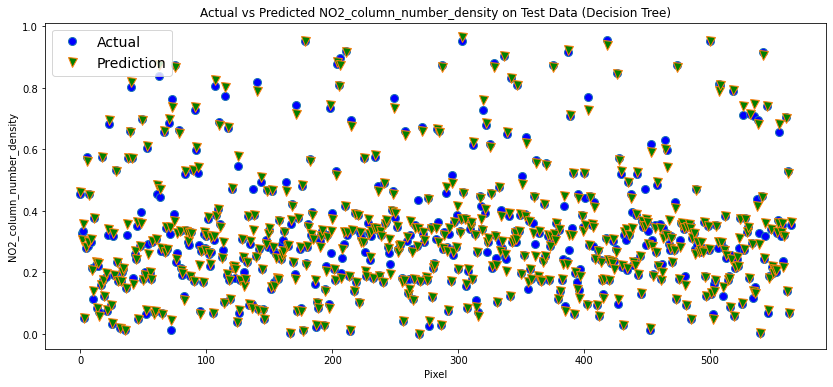

In [54]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(alpha=0.85, learning_rate=0.5, loss='lad', max_depth=15, max_features=0.9500000000000001,
                                min_samples_leaf=12, min_samples_split=7, n_estimators=100, subsample=0.6500000000000001)
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
#print(prediction[0,0])

MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Decision Tree)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

In [55]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.999
Test Accuracy : 0.991


In [56]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

In [57]:
exported_pipeline = RandomForestRegressor(bootstrap=False, max_features=0.4, min_samples_leaf=16, min_samples_split=14, n_estimators=100)


In [58]:
exported_pipeline.fit(X_train,y_train)
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.999
Test Accuracy : 0.991
